In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # Deep learning framework
import torch.nn.functional as F
import time

# Input data files are available in the "../input/" directory.
import os
INPUTDIR = 'input'
print(os.listdir(f'{INPUTDIR}'))

#Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Constants

NUM_CLASSES = 235
INPUT_DIR = "input/"
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 256

with open(os.path.join(INPUT_DIR, "x_train.txt"), encoding="utf8") as f:
    data = f.read()

x_train = data.split('\n')

with open(os.path.join(INPUT_DIR, "x_test.txt"), encoding="utf8") as f:
    data = f.read()

x_test = data.split('\n')

with open(os.path.join(INPUT_DIR, "y_train.txt"), encoding="utf8") as f:
    data = f.read()

y_train = data.split('\n')

with open(os.path.join(INPUT_DIR, "y_test.txt"), encoding="utf8") as f:
    data = f.read()

y_test = data.split('\n')

x_train.pop(-1)
x_test.pop(-1)
y_train.pop(-1)
y_test.pop(-1)


x_train = pd.DataFrame(x_train, columns=['sentence'])
y_train = pd.DataFrame(y_train, columns=['language'])

x_test = pd.DataFrame(x_test, columns=['sentence'])
y_test = pd.DataFrame(y_test, columns=['language'])

print(x_train.shape)
print(x_test.shape)


print('Example:')
print('LANG =', y_train['language'].iloc[0])
print('TEXT =', x_train['sentence'].iloc[0])

x_train_sentence = x_train['sentence']
y_train_language = y_train['language']

x_test_sentence = x_train['sentence']
y_test_language = y_train['language']

['x_train.txt', 'labels.csv', 'y_train.txt', 'x_test.txt', 'y_test.txt', 'README.md', '.ipynb_checkpoints', 'urls.txt']
cpu
(117500, 1)
(117500, 1)
Example:
LANG = est
TEXT = Klement Gottwaldi surnukeha palsameeriti ning paigutati mausoleumi. Surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemärke. 1962. aastal viidi ta surnukeha mausoleumist ära ja kremeeriti. Zlíni linn kandis aastatel 1949–1989 nime Gottwaldov. Ukrainas Harkivi oblastis kandis Zmiivi linn aastatel 1976–1990 nime Gotvald.


In [37]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

In [38]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set
chars = set(''.join(x_train_sentence))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

lang_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
languages = set(y_train_language)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "languages")

Vocabulary: 10808 UTF characters
Labels: 235 languages


In [39]:
#From token or label to index
print('k ->', char_vocab.token2idx['k'])
print('est ->', lang_vocab.token2idx['est'])
print(y_train_language[0], x_train_sentence[0][:10])
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_sentence]
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_language])
print(y_train_idx[0], x_train_idx[0][:10])

k -> 77
est -> 52
est Klement Go
52 [45 78 71 79 71 80 86  2 41 81]


In [41]:
from sklearn.model_selection import train_test_split

x_test_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_test_sentence]
y_test_idx = np.array([lang_vocab.token2idx[lang] for lang in y_test_language])

x_test, x_val, y_test, y_val = train_test_split(x_test_idx, y_test_idx, test_size=0.2, random_state=42)
train_data = [(x, y) for x, y in zip(x_train_sentence, y_train_language)]
test_data = [(x, y) for x, y in zip(x_test, y_test)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(test_data), "test samples")
print(len(val_data), "validation samples")

117500 training samples
94000 test samples
23500 validation samples


In [45]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [46]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

In [47]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        output, _ = padded.max(dim=0)
        # B x H
        output = self.h2o(output)
        # B x O
        return output

In [48]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

In [49]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [50]:
def train(model, optimizer, data, batch_size, token_size, max_norm=1, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # Get input and target sequences from batch
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)      # Gradient clipping https://www.kaggle.com/c/wili4/discussion/231378
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
    
    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [51]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

In [52]:
hidden_size = 256
embedding_size = 64
bidirectional = False
ntokens = len(char_vocab)
nlabels = len(lang_vocab)

In [53]:
def get_model():
    model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [54]:
batch_size, token_size = 256, 200000
epochs = 25
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model()
print(f'Training cross-validation model for {epochs} epochs')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')
    acc = validate(model, val_data, batch_size, token_size)
    valid_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%')

AssertionError: Torch not compiled with CUDA enabled

In [55]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

NameError: name 'model' is not defined

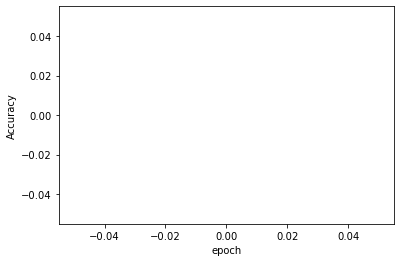

In [56]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');